In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, f1_score
import matplotlib.pyplot as plt


Mounted at /content/drive


In [2]:
import pandas as pd

# Assuming your file is in Excel format, use read_excel
data = pd.read_csv('/content/drive/MyDrive/stroke/bank1.csv')
data.head()

age  job  marital  education  default  balance  housing  loan  contact  \
0   59    0        1          1        0     2343        1     0        2   
1   56    0        1          1        0       45        0     0        2   
2   41    9        1          1        0     1270        1     0        2   
3   55    7        1          1        0     2476        1     0        2   
4   54    0        1          2        0      184        0     0        2   

   day  month  duration  campaign  pdays  previous  poutcome  deposit  
0    5      8      1042         1     -1         0         3        1  
1    5      8      1467         1     -1         0         3        1  
2    5      8      1389         1     -1         0         3        1  
3    5      8       579         1     -1         0         3        1  
4    5      8       673         2     -1         0         3        1

In [3]:


# Split features and target
X = data.drop('deposit', axis=1)
y = data['deposit']

# Display the encoded dataset
print(X)
print(y)


       age  job  marital  education  default  balance  housing  loan  contact  \
0       59    0        1          1        0     2343        1     0        2   
1       56    0        1          1        0       45        0     0        2   
2       41    9        1          1        0     1270        1     0        2   
3       55    7        1          1        0     2476        1     0        2   
4       54    0        1          2        0      184        0     0        2   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
11157   33    1        2          0        0        1        1     0        0   
11158   39    7        1          1        0      733        0     0        2   
11159   32    9        2          1        0       29        0     0        0   
11160   43    9        1          1        0        0        0     1        0   
11161   34    9        1          1        0        0        0     0        0   

       day  month  duration

Feature Importance Scores (CfssSubsetEval with PCA mapped to original features):
poutcome     0.049047
pdays        0.048862
previous     0.043910
month        0.028325
balance      0.027664
age          0.027013
marital      0.023671
housing      0.020315
education    0.017716
job          0.014870
default      0.014735
contact      0.010990
day          0.010027
duration     0.008143
loan         0.007222
campaign     0.006735
dtype: float64


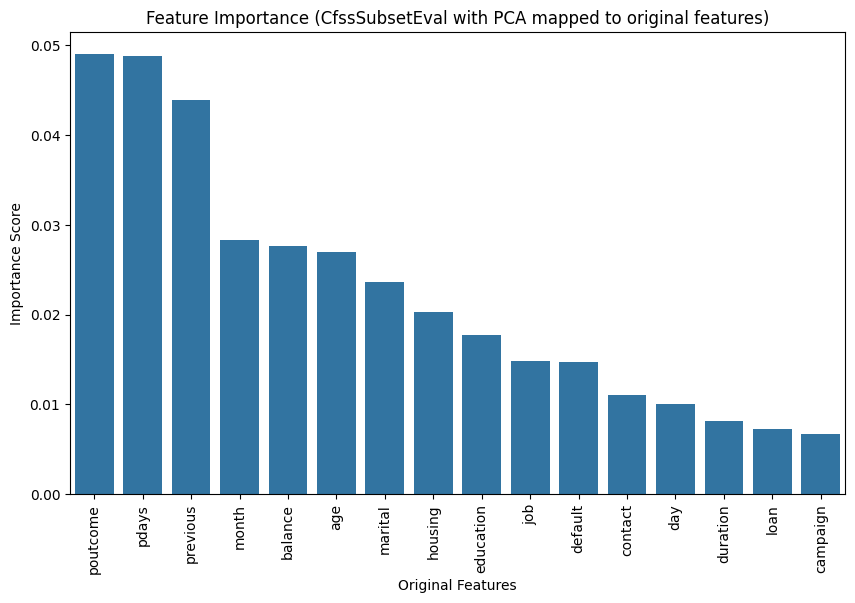


Selected Features (Threshold-Based Selection):
poutcome     0.049047
pdays        0.048862
previous     0.043910
month        0.028325
balance      0.027664
age          0.027013
marital      0.023671
housing      0.020315
education    0.017716
job          0.014870
default      0.014735
contact      0.010990
day          0.010027
duration     0.008143
loan         0.007222
campaign     0.006735
dtype: float64

Selected Top-10 Features:
poutcome     0.049047
pdays        0.048862
previous     0.043910
month        0.028325
balance      0.027664
age          0.027013
marital      0.023671
housing      0.020315
education    0.017716
job          0.014870
dtype: float64

Selected Features (Cumulative Importance up to 80.0%):
poutcome     0.049047
pdays        0.048862
previous     0.043910
month        0.028325
balance      0.027664
age          0.027013
marital      0.023671
housing      0.020315
education    0.017716
dtype: float64


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to hold feature importance scores across folds
importance_scores = np.zeros(X.shape[1])

# Perform cross-validation
for train_index, test_index in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply PCA to retain 95% of the variance
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Evaluate the importance of principal components using mutual information
    mi = mutual_info_classif(X_train_pca, y_train)
    pc_importance = pd.Series(mi, index=[f'PC{i+1}' for i in range(X_train_pca.shape[1])]).sort_values(ascending=False)

    # Get the loadings (components)
    loadings = pca.components_

    # Calculate the importance of the original features
    original_feature_importance = np.abs(np.dot(loadings.T, pc_importance.values))
    importance_scores += original_feature_importance

# Average the importance scores across folds
importance_scores /= kf.n_splits
original_feature_importance_series = pd.Series(importance_scores, index=X.columns).sort_values(ascending=False)

# Print the feature importance scores of the original features
print("Feature Importance Scores (CfssSubsetEval with PCA mapped to original features):")
print(original_feature_importance_series)

# Plot the feature importance of the original features
plt.figure(figsize=(10, 6))
sns.barplot(x=original_feature_importance_series.index, y=original_feature_importance_series.values)
plt.title('Feature Importance (CfssSubsetEval with PCA mapped to original features)')
plt.xlabel('Original Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.show()

# Threshold-Based Selection
threshold = 0.003
selected_features_threshold = original_feature_importance_series[original_feature_importance_series > threshold]
print("\nSelected Features (Threshold-Based Selection):")
print(selected_features_threshold)

# Top-N Features Selection
top_n = 10
selected_features_top_n = original_feature_importance_series.head(top_n)
print(f"\nSelected Top-{top_n} Features:")
print(selected_features_top_n)

# Cumulative Importance Selection
cumulative_importance_threshold = 0.80
cumulative_importance = original_feature_importance_series.cumsum() / original_feature_importance_series.sum()
selected_features_cumulative = original_feature_importance_series[cumulative_importance <= cumulative_importance_threshold]
print(f"\nSelected Features (Cumulative Importance up to {cumulative_importance_threshold * 100}%):")
print(selected_features_cumulative)


Feature Importance Scores (GainRatioAttributeEval with PCA mapped to original features):
previous     4.242194
pdays        2.334960
poutcome     1.803015
age          0.975484
housing      0.820990
marital      0.801838
campaign     0.544924
contact      0.501889
month        0.488032
balance      0.286451
loan         0.216206
duration     0.207003
default      0.199127
job          0.192260
education    0.073575
day          0.051515
dtype: float64


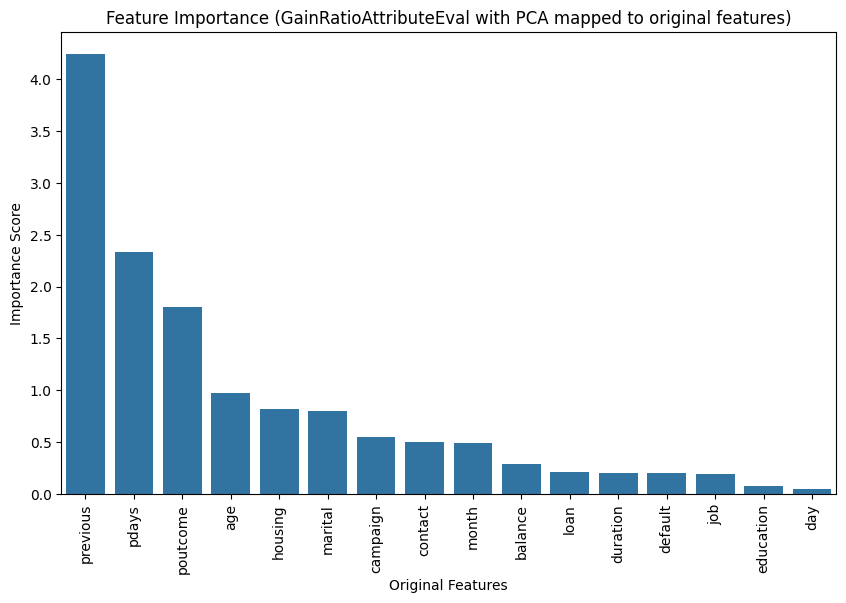


Cross-Validation Scores:
[0.85324659 0.85265656 0.89767747 0.91524702 0.91058153]

Selected Features (Threshold-Based Selection):
previous     4.242194
pdays        2.334960
poutcome     1.803015
age          0.975484
housing      0.820990
marital      0.801838
campaign     0.544924
contact      0.501889
month        0.488032
balance      0.286451
loan         0.216206
duration     0.207003
default      0.199127
job          0.192260
education    0.073575
day          0.051515
dtype: float64

Selected Top-10 Features:
previous    4.242194
pdays       2.334960
poutcome    1.803015
age         0.975484
housing     0.820990
marital     0.801838
campaign    0.544924
contact     0.501889
month       0.488032
balance     0.286451
dtype: float64

Selected Features (Cumulative Importance up to 80.0%):
previous    4.242194
pdays       2.334960
poutcome    1.803015
age         0.975484
housing     0.820990
marital     0.801838
dtype: float64


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns



# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Calculate Information Gain (mutual information) for principal components
ig = mutual_info_classif(X_pca, y)

# Calculate Intrinsic Value for each principal component
X_pca_abs = np.abs(X_pca)
intrinsic_value = -np.sum(X_pca_abs * np.log2(X_pca_abs + 1e-9), axis=0) / len(X_pca)

# Compute Gain Ratio for each principal component
gain_ratio = ig / (intrinsic_value + 1e-9)  # Adding a small constant to avoid division by zero
pc_importance = pd.Series(gain_ratio, index=[f'PC{i+1}' for i in range(X_pca.shape[1])]).sort_values(ascending=False)

# Get the loadings (components)
loadings = pca.components_

# Calculate the importance of the original features
original_feature_importance = np.abs(np.dot(loadings.T, pc_importance.values))
original_feature_importance_series = pd.Series(original_feature_importance, index=X.columns).sort_values(ascending=False)

# Print the feature importance scores of the original features
print("Feature Importance Scores (GainRatioAttributeEval with PCA mapped to original features):")
print(original_feature_importance_series)

# Plot the feature importance of the original features
plt.figure(figsize=(10, 6))
sns.barplot(x=original_feature_importance_series.index, y=original_feature_importance_series.values)
plt.title('Feature Importance (GainRatioAttributeEval with PCA mapped to original features)')
plt.xlabel('Original Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.show()

# Cross-validation for feature importance evaluation
model = RandomForestClassifier()  # You can use any classifier for cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='roc_auc')  # Using ROC AUC as the scoring metric

print("\nCross-Validation Scores:")
print(cv_scores)

# Threshold-Based Selection
threshold = 0.003
selected_features_threshold = original_feature_importance_series[original_feature_importance_series > threshold]
print("\nSelected Features (Threshold-Based Selection):")
print(selected_features_threshold)

# Top-N Features Selection
top_n = 10
selected_features_top_n = original_feature_importance_series.head(top_n)
print(f"\nSelected Top-{top_n} Features:")
print(selected_features_top_n)

# Cumulative Importance Selection
cumulative_importance_threshold = 0.80
cumulative_importance = original_feature_importance_series.cumsum() / original_feature_importance_series.sum()
selected_features_cumulative = original_feature_importance_series[cumulative_importance <= cumulative_importance_threshold]
print(f"\nSelected Features (Cumulative Importance up to {cumulative_importance_threshold * 100}%):")
print(selected_features_cumulative)


In [6]:
!pip install skrebate

  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29255 sha256=3b9e8419470db0988c10371fe72e813a3fcf8ec04ec2266a53478c429ceec8aa
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built skrebate


Feature Importance Scores (ReliefFAttributeEval):
duration     0.251231
day          0.044380
month        0.037659
job          0.034010
age          0.028024
poutcome     0.022586
campaign     0.012696
pdays        0.012124
education    0.008180
balance      0.006325
contact      0.004569
previous     0.004287
loan         0.003136
marital      0.002992
housing      0.002141
default      0.000349
dtype: float64


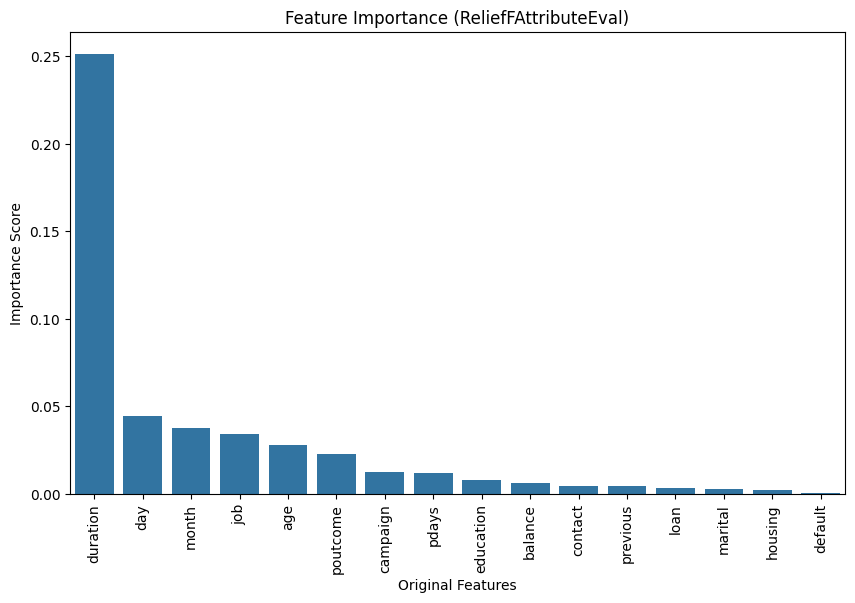


Cross-Validation Scores:
[0.85615815 0.85210433 0.89721856 0.91621957 0.90979368]

Selected Features (Threshold-Based Selection):
duration     0.251231
day          0.044380
month        0.037659
job          0.034010
age          0.028024
poutcome     0.022586
campaign     0.012696
pdays        0.012124
education    0.008180
balance      0.006325
contact      0.004569
previous     0.004287
loan         0.003136
dtype: float64

Selected Top-10 Features:
duration     0.251231
day          0.044380
month        0.037659
job          0.034010
age          0.028024
poutcome     0.022586
campaign     0.012696
pdays        0.012124
education    0.008180
balance      0.006325
dtype: float64

Selected Features (Cumulative Importance up to 80.0%):
duration    0.251231
day         0.044380
month       0.037659
job         0.034010
dtype: float64


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from skrebate import ReliefF
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data loaded in X and y as per your previous code

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure the data is in floating-point format
X_float = X_scaled.astype(np.float64)
y_float = y.astype(np.float64)

# Evaluate the importance of original features using ReliefF
relief = ReliefF(n_neighbors=10, n_features_to_select=X.shape[1])
X_relief = relief.fit_transform(X_float, y_float)  # Transform X using ReliefF
feature_importances = relief.feature_importances_

# Print the feature importance scores of the original features
original_feature_importance_series = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
print("Feature Importance Scores (ReliefFAttributeEval):")
print(original_feature_importance_series)

# Plot the feature importance of the original features
plt.figure(figsize=(10, 6))
sns.barplot(x=original_feature_importance_series.index, y=original_feature_importance_series.values)
plt.title('Feature Importance (ReliefFAttributeEval)')
plt.xlabel('Original Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.show()

# Cross-validation for feature importance evaluation
model = RandomForestClassifier()  # You can use any classifier for cross-validation
cv_scores = cross_val_score(model, X_float, y_float, cv=5, scoring='roc_auc')  # Using ROC AUC as the scoring metric

print("\nCross-Validation Scores:")
print(cv_scores)

# Threshold-Based Selection
threshold = 0.003
selected_features_threshold = original_feature_importance_series[original_feature_importance_series > threshold]
print("\nSelected Features (Threshold-Based Selection):")
print(selected_features_threshold)

# Top-N Features Selection
top_n = 10
selected_features_top_n = original_feature_importance_series.head(top_n)
print(f"\nSelected Top-{top_n} Features:")
print(selected_features_top_n)

# Cumulative Importance Selection
cumulative_importance_threshold = 0.80
cumulative_importance = original_feature_importance_series.cumsum() / original_feature_importance_series.sum()
selected_features_cumulative = original_feature_importance_series[cumulative_importance <= cumulative_importance_threshold]
print(f"\nSelected Features (Cumulative Importance up to {cumulative_importance_threshold * 100}%):")
print(selected_features_cumulative)


Feature Importance Scores (PCA-IG mapped to original features):
duration     0.062450
balance      0.046926
previous     0.044983
poutcome     0.037985
pdays        0.037441
housing      0.026462
day          0.018916
marital      0.016708
age          0.014179
month        0.010771
default      0.009340
contact      0.008436
job          0.007939
loan         0.007807
campaign     0.002110
education    0.000409
dtype: float64


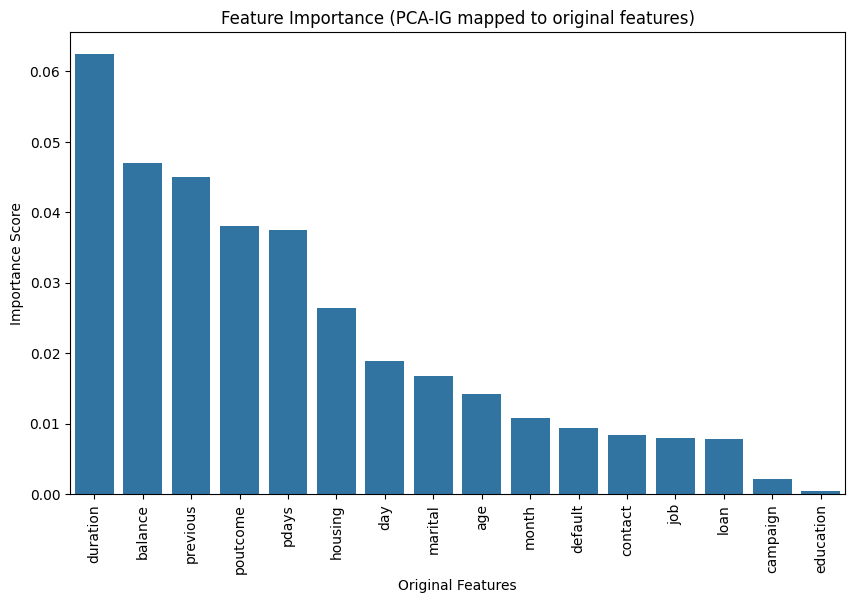


Selected Features (Threshold-Based Selection):
duration    0.062450
balance     0.046926
previous    0.044983
poutcome    0.037985
pdays       0.037441
housing     0.026462
day         0.018916
marital     0.016708
age         0.014179
month       0.010771
default     0.009340
contact     0.008436
job         0.007939
loan        0.007807
campaign    0.002110
dtype: float64

Selected Top-10 Features:
duration    0.062450
balance     0.046926
previous    0.044983
poutcome    0.037985
pdays       0.037441
housing     0.026462
day         0.018916
marital     0.016708
age         0.014179
month       0.010771
dtype: float64

Selected Features (Cumulative Importance up to 90.0%):
duration    0.062450
balance     0.046926
previous    0.044983
poutcome    0.037985
pdays       0.037441
housing     0.026462
day         0.018916
marital     0.016708
age         0.014179
month       0.010771
dtype: float64

Cross-validated Feature Importance Scores:
{'duration': 0.680522048708923, 'balance': 0.

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Evaluate the importance of principal components using mutual information
mi = mutual_info_classif(X_pca, y)
pc_importance = pd.Series(mi, index=[f'PC{i+1}' for i in range(X_pca.shape[1])]).sort_values(ascending=False)

# Get the loadings (components)
loadings = pca.components_

# Calculate the importance of the original features using PCA-IG
pca_ig_importance = np.abs(np.dot(loadings.T, mi))
pca_ig_importance_series = pd.Series(pca_ig_importance, index=X.columns).sort_values(ascending=False)

# Print the feature importance scores using PCA-IG
print("Feature Importance Scores (PCA-IG mapped to original features):")
print(pca_ig_importance_series)

# Plot the feature importance using PCA-IG
plt.figure(figsize=(10, 6))
sns.barplot(x=pca_ig_importance_series.index, y=pca_ig_importance_series.values)
plt.title('Feature Importance (PCA-IG mapped to original features)')
plt.xlabel('Original Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.show()

# Cross-validation for feature importance evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Threshold-Based Selection
threshold = 0.002
original_feature_importance_series = pca_ig_importance_series  # Assuming you use pca_ig_importance_series
selected_features_threshold = original_feature_importance_series[original_feature_importance_series > threshold]
print("\nSelected Features (Threshold-Based Selection):")
print(selected_features_threshold)

# Top-N Features Selection
top_n = 10
selected_features_top_n = original_feature_importance_series.head(top_n)
print(f"\nSelected Top-{top_n} Features:")
print(selected_features_top_n)

# Cumulative Importance Selection
cumulative_importance_threshold = 0.90
cumulative_importance = original_feature_importance_series.cumsum() / original_feature_importance_series.sum()
selected_features_cumulative = original_feature_importance_series[cumulative_importance <= cumulative_importance_threshold]
print(f"\nSelected Features (Cumulative Importance up to {cumulative_importance_threshold * 100}%):")
print(selected_features_cumulative)

# Evaluate cross-validated feature importance for selected features
def evaluate_feature_importance_cv(X, y, cv):
    def cross_val_feature_importance(model, X, y, cv):
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return np.mean(scores)

    # Example: Select top features based on some selection method (threshold, top_n, cumulative)
    selected_features = selected_features_threshold.index  # Replace with selected features based on method

    # Example: Evaluate feature importance using a classifier (e.g., RandomForestClassifier)
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(random_state=42)
    feature_importance_scores = {}

    for feature in selected_features:
        X_feature = X[feature].values.reshape(-1, 1)
        score = cross_val_feature_importance(model, X_feature, y, cv)
        feature_importance_scores[feature] = score

    return feature_importance_scores

# Example usage:
feature_importance_scores = evaluate_feature_importance_cv(X, y, cv)
print("\nCross-validated Feature Importance Scores:")
print(feature_importance_scores)
